<h1>I. Import library and dataset 

In [1358]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patheffects as PathEffects
import seaborn as sns
sns.set(style="whitegrid", rc={'axes.grid': False})
plt.rcParams.update({'font.size': 12})

from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings('ignore')

In [1359]:
data = pd.read_csv(r"C:\Users\PC\Downloads\Mall_Customers.csv")

In [1360]:
data

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


Columns Genre, Annual Income (k$) and Spending Score (1-100) should be renamed 

In [1361]:
data.rename(columns={'Genre': 'Gender', 'Annual Income (k$)':'Annual Income', 'Spending Score (1-100)':'Spending Score'}, inplace=True)

<h1>II. EDA + Preprocessing 

<h2>1. Missing value 

In [1362]:
data.describe()

,CustomerID,Age,Annual Income,Spending Score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [1363]:
data.duplicated().sum()

0

<h2>2. Outlier

<h3>2.1. Age

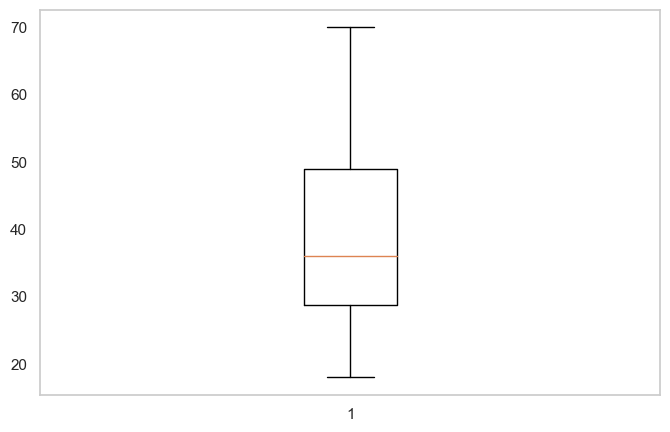

In [1364]:
fig, ax = plt.subplots(figsize=(8, 5)) 

bp = ax.boxplot(data['Age'])

plt.show()

<h3>2.2. Annual Income

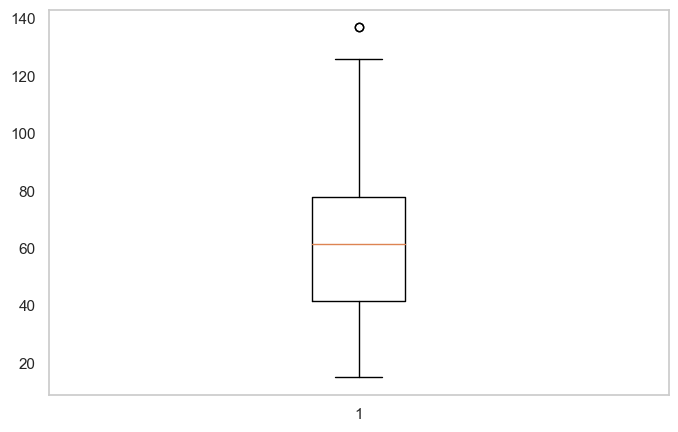

In [1365]:
fig, ax = plt.subplots(figsize=(8, 5)) 

bp = ax.boxplot(data['Annual Income'])

plt.show()

In [1366]:
data[data['Annual Income'] == data['Annual Income'].max()]

,CustomerID,Gender,Age,Annual Income,Spending Score
198,199,Male,32,137,18
199,200,Male,30,137,83


There are 2 customer with 137k$ annual income, considered as outliers 

<h3>2.3. Spending score

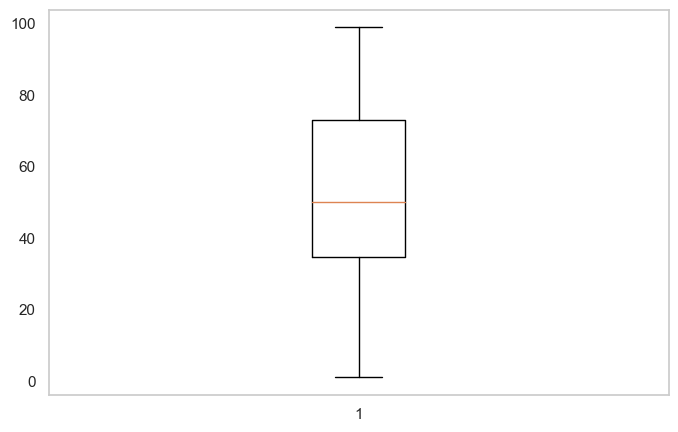

In [1367]:
fig, ax = plt.subplots(figsize=(8, 5)) 

bp = ax.boxplot(data['Spending Score'])

plt.show()

<h3>2.4. Gender 

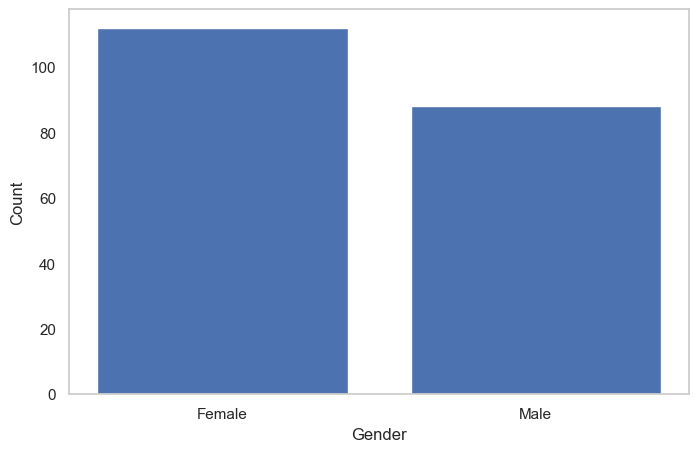

In [1368]:
fig, ax = plt.subplots(figsize=(8, 5)) 

gender_counts = data['Gender'].value_counts() 
bar = ax.bar(gender_counts.index, gender_counts.values)

ax.set_xlabel('Gender') 
ax.set_ylabel('Count')

ax.set_xticks(range(len(gender_counts))) 
ax.set_xticklabels(gender_counts.index) 

plt.show()

There is just a mild imbalance in gender feature. However, gender is not a feature used for clustering, so it will not be addressed 

<h2>3. Encoding 

In [1369]:
data.drop('CustomerID', axis=1, inplace=True)

In [1370]:
encode = OrdinalEncoder()
data['Gender'] = encode.fit_transform(data[['Gender']])

<h2>4. Feature scaling 

Numerical features like 'Age', 'Annual Income', 'Spending Score' are not in the same value range, so those should be rescaled 

In [1371]:
scaler = MinMaxScaler()
data[['Age', 'Annual Income', 'Spending Score']] = scaler.fit_transform(data[['Age', 'Annual Income', 'Spending Score']])

<h2>5. Feature selection 

There could be various combinations of features to perform the segmentation, but for the purpose of testing how effectively different models work, I have only used annual income and spending score

In [1372]:
data_income_spending_score = data[['Annual Income', 'Spending Score']]

<h1>III. Models

<h2>1. Segmentation using Annual Income and Spending Score

<h3>1.1. K-means

The Elbow Method is used to determine the most suitable number of clusters.

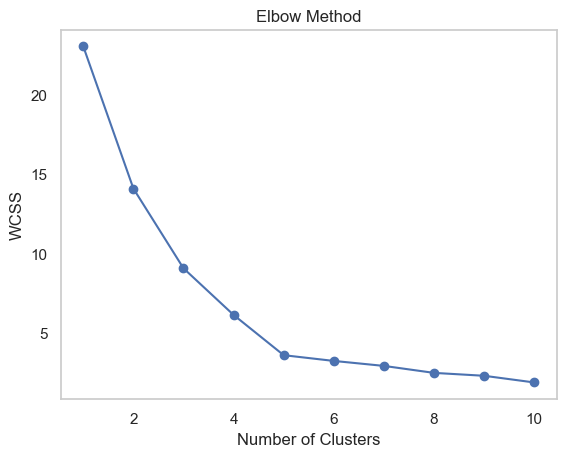

In [1373]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_income_spending_score)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

Number of cluster from 5 to 8 could be the best threshhold.

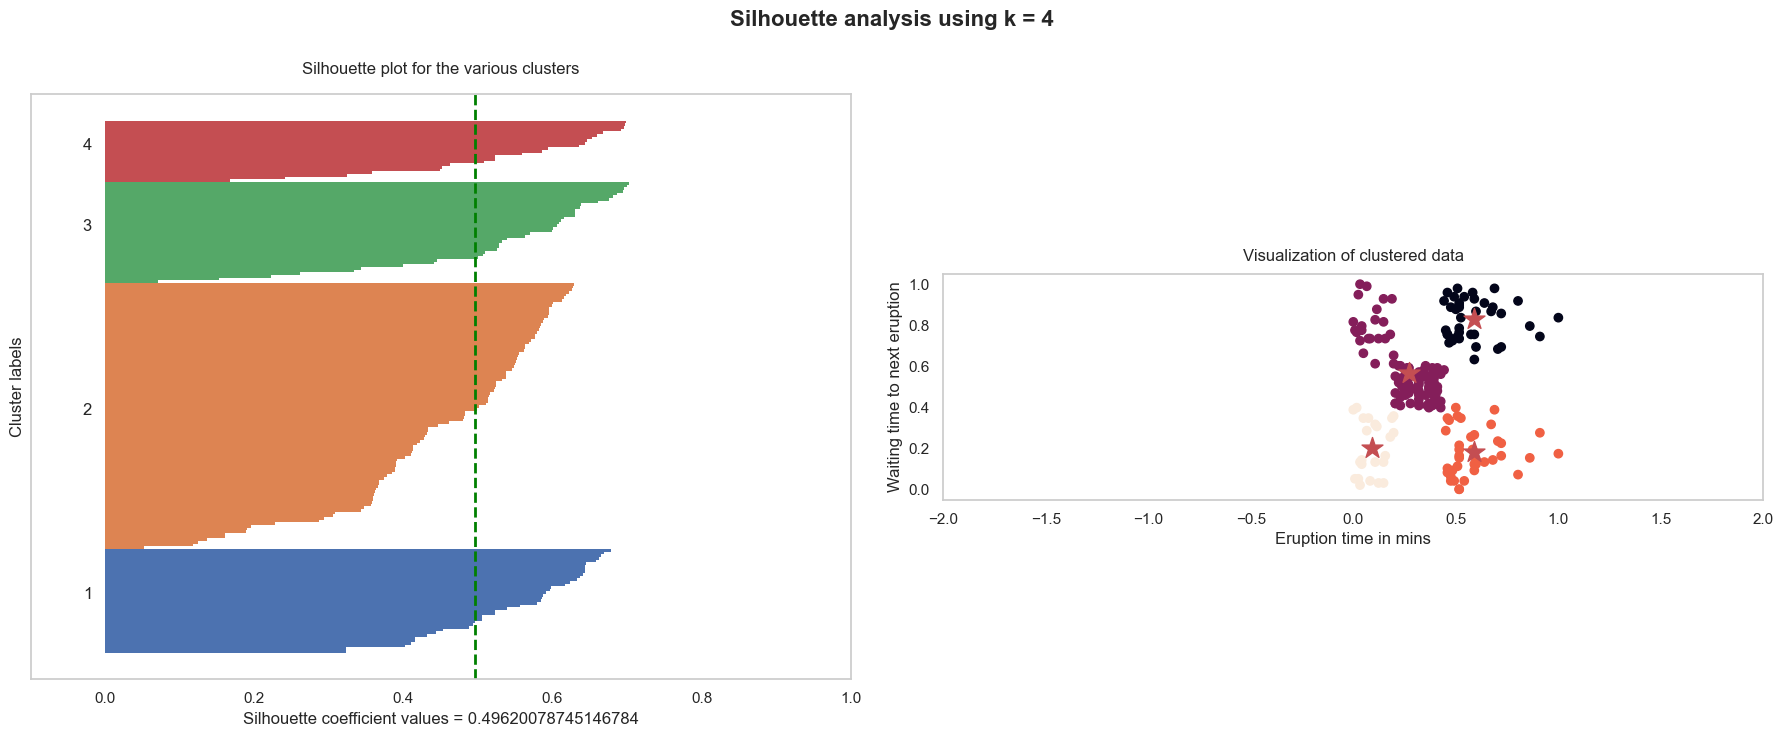

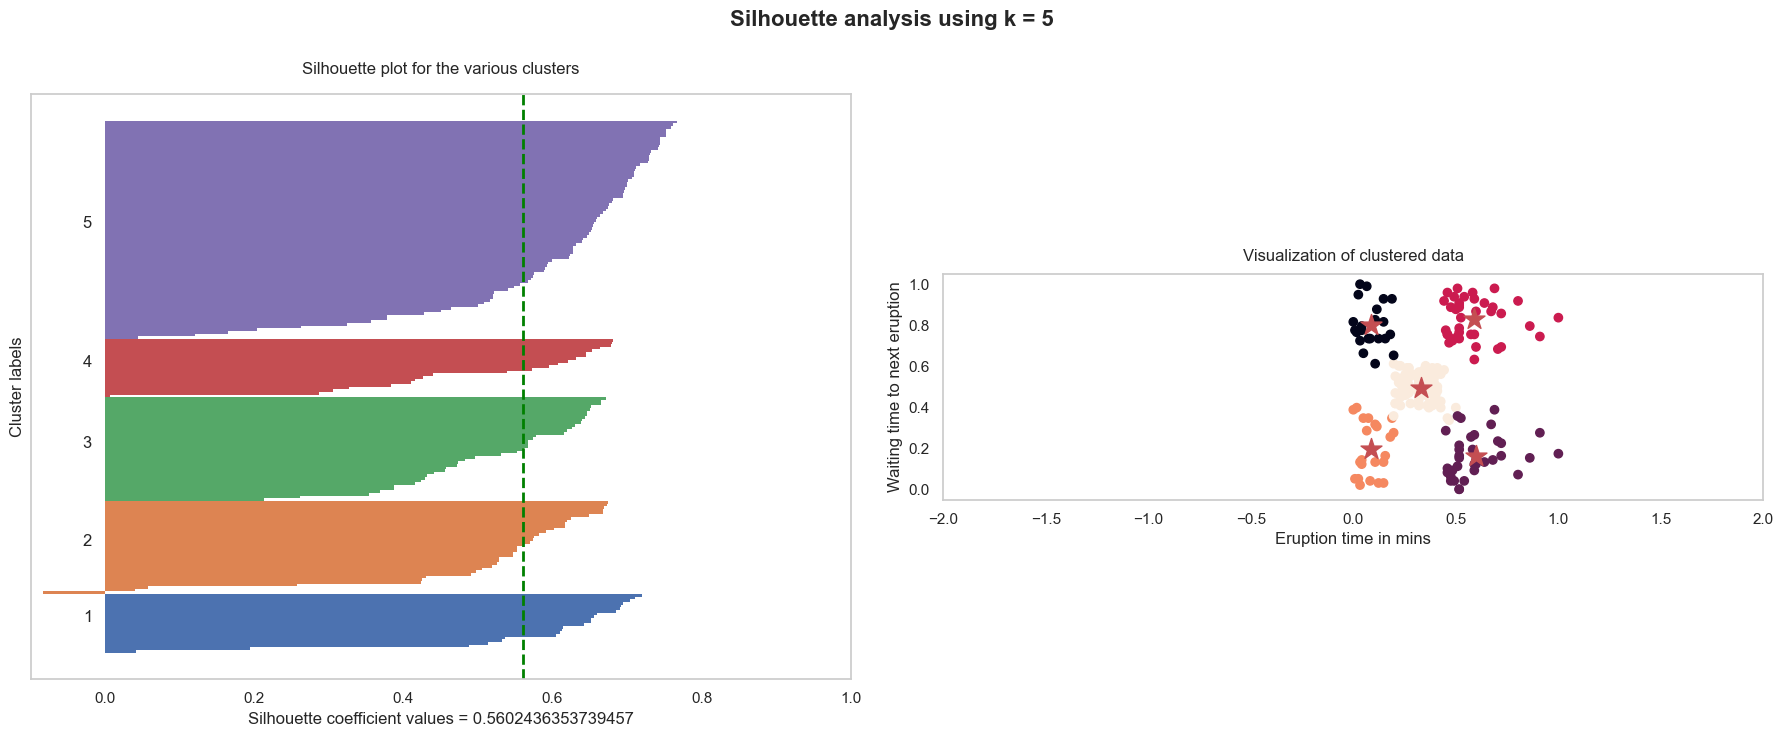

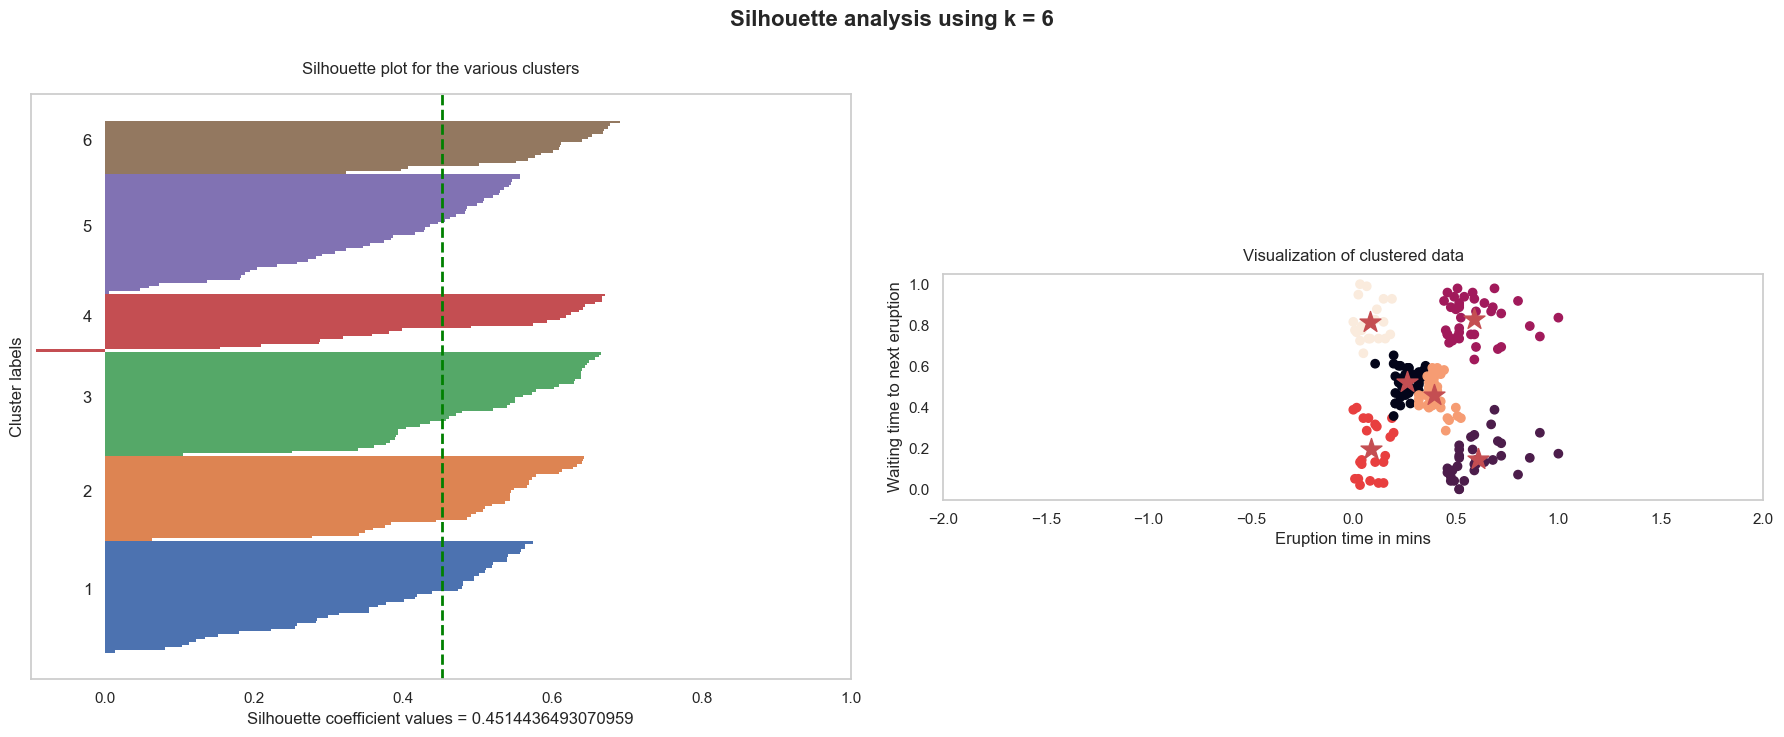

In [1374]:
data_selection_np = data_income_spending_score.values 
for i, k in enumerate([4, 5, 6]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    km = KMeans(n_clusters=k)
    labels = km.fit_predict(data_selection_np)
    centroids = km.cluster_centers_

    silhouette_vals = silhouette_samples(data_selection_np, labels)

    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel(f'Silhouette coefficient values = {avg_score}')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
 
    ax2.scatter(data_selection_np[:, 0], data_selection_np[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('Eruption time in mins')
    ax2.set_ylabel('Waiting time to next eruption')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05)

As we can see above, using 5 clusters could provide the best results in terms of both visualization and silhouette coefficient value.

<h3> 1.2. DBSCAN

MinPts should be at least twice the number of dimensions, which for our case (2 * 5) equals 10. Hence, I'll choose 11 for MinPts. The number of k-neighbors should be MinPts - 1, so k-neighbor = 11 - 1 = 10. This approach follows the author's guidelines as detailed [15.4.1. Lựa chọn tham số cho mô hình DBSCAN](https://phamdinhkhanh.github.io/deepai-book/ch_ml/DBSCAN.html#lua-chon-tham-so-cho-mo-hinh-dbscan).


Determining the Optimal Epsilon (eps) for DBSCAN Using k-Nearest Neighbors (kNN)

Text(0.5, 1.0, 'Sorting Maximum Distance in k Nearest Neighbor of kNN')

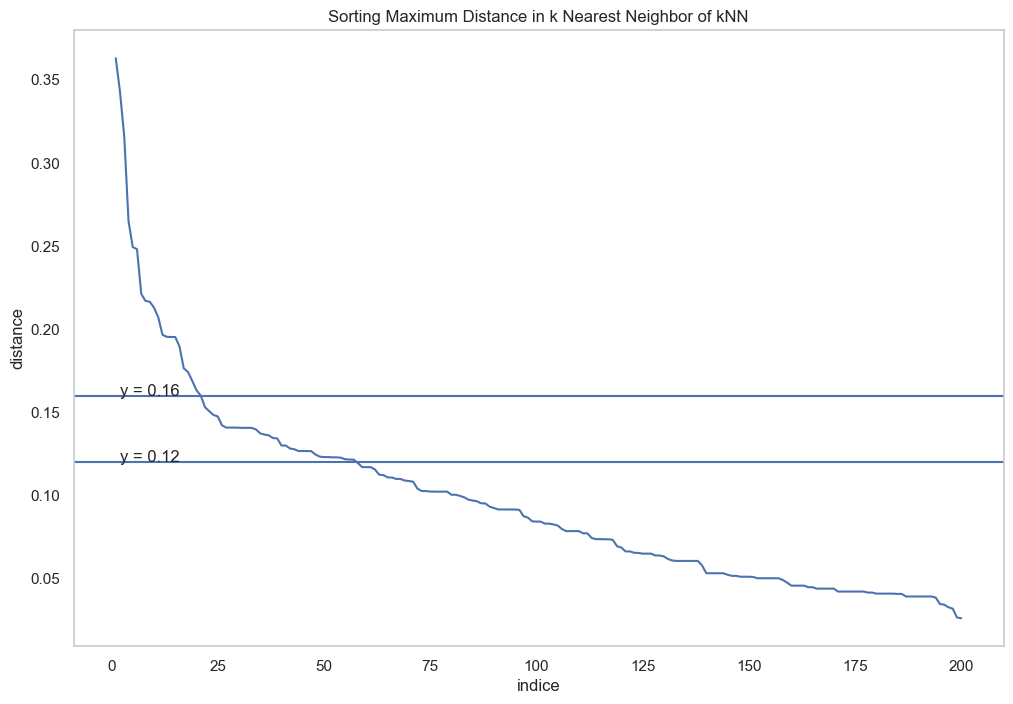

In [1375]:
neighbors = 10
nbrs = NearestNeighbors(n_neighbors=neighbors ).fit(data_income_spending_score)

distances, indices = nbrs.kneighbors(data_income_spending_score)

distance_desc = sorted(distances[:, neighbors-1], reverse=True)

plt.figure(figsize=(12, 8))
plt.plot(list(range(1,len(distance_desc )+1)), distance_desc)
plt.axhline(y=0.12)
plt.text(2, 0.12, 'y = 0.12', fontsize=12)
plt.axhline(y=0.16)
plt.text(2, 0.16, 'y = 0.16', fontsize=12)
plt.ylabel('distance')
plt.xlabel('indice')
plt.title('Sorting Maximum Distance in k Nearest Neighbor of kNN')

From the k-distance plot, we can see the elbow point corresponding to epsilon in the range [0.12, 0.16]. Next, we will search for the value of the parameter epsilon in this range for the DBSCAN model. The parameter minPts is fixed at 11, as initially chosen, to correspond with the k-Means plot.

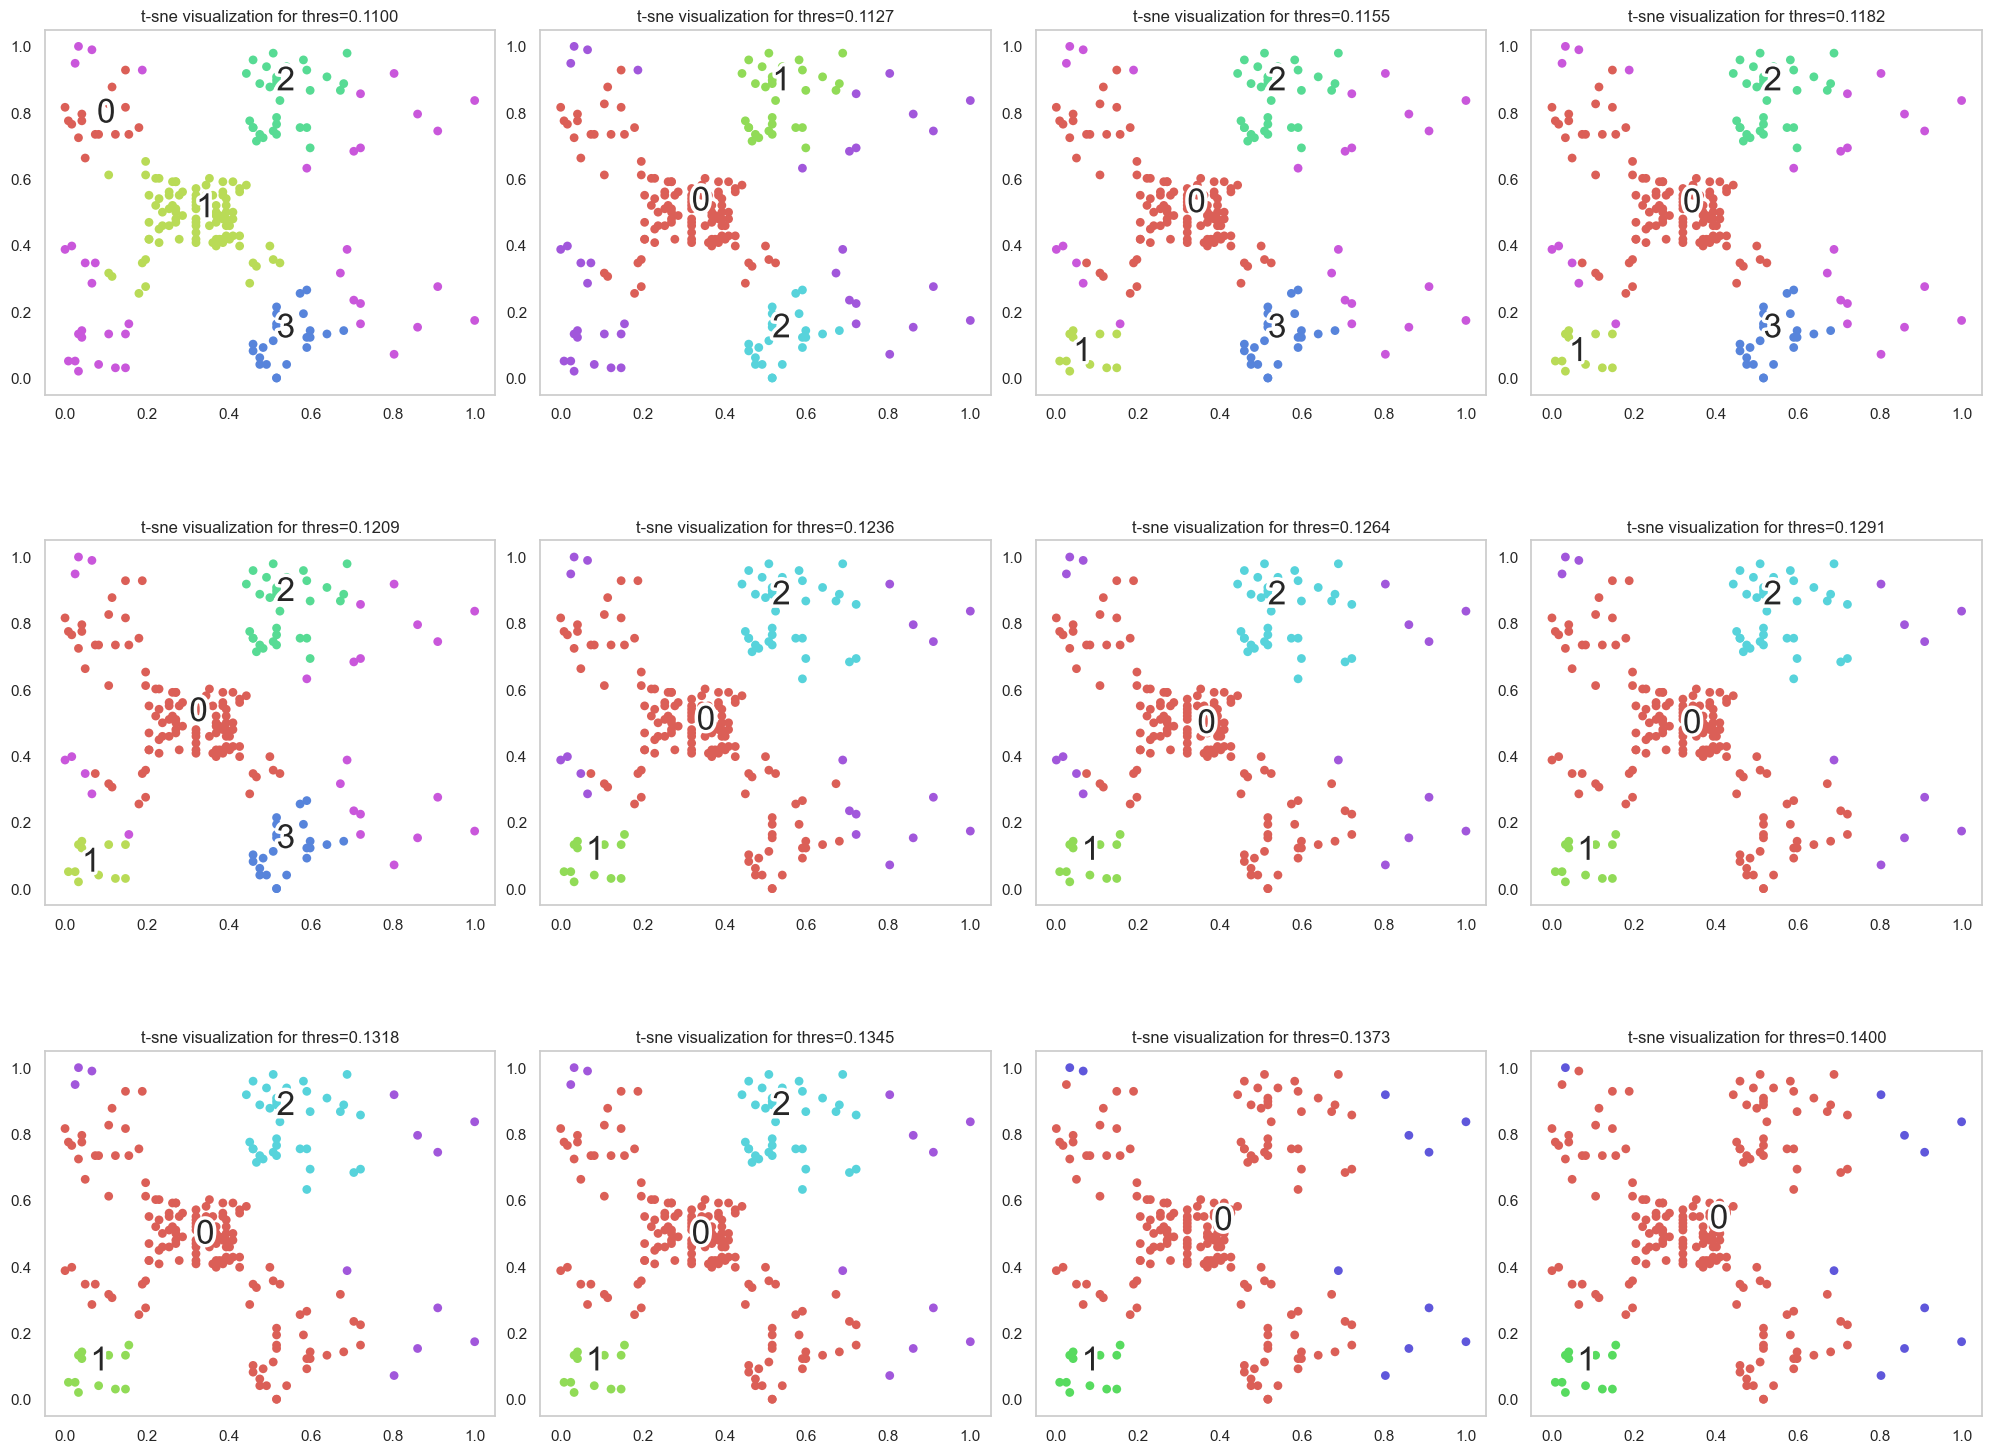

In [1376]:
def _plot_kmean_scatter(X, labels, gs, thres):
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", num_classes))

    ax = plt.subplot(gs)
    sc = ax.scatter(X[:, 0], X[:, 1], lw=0, s=40, c=palette[labels.astype(int)]) 

    txts = []

    for i in range(num_classes):
        indices = (labels == i)
        xtext, ytext = np.median(X[indices, :], axis=0)
        if not (np.isnan(xtext) or np.isnan(ytext)):        
            txt = ax.text(xtext, ytext, str(i), fontsize=24)
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground="w"),
                PathEffects.Normal()])
            txts.append(txt)
    plt.title('t-sne visualization for thres={:.4f}'.format(thres))

gs = GridSpec(3, 4)
plt.figure(figsize=(25, 18))
plt.subplots_adjust(wspace=0.1, hspace=0.4)

for i, thres in enumerate(np.linspace(0.11, 0.14, 12)):
    dbscan = DBSCAN(eps=thres, min_samples=11, metric='euclidean')
    labels = dbscan.fit_predict(data_selection_np)
    _plot_kmean_scatter(data_selection_np, labels, gs[i], thres)

plt.show()


The value of epsilon significantly affects the clustering results. Based on the plot, we can choose epsilon = 0.1209 as the value that appears to provide the most general clustering results on the training dataset. This value may vary according to the data normalization method and the choice of input data fields.

In [1377]:
epsilon = 0.1209
dbscan = DBSCAN(eps=epsilon, min_samples=11, metric='euclidean')
labels = dbscan.fit_predict(data_income_spending_score)

if len(set(labels)) > 1:
    valid_points = labels != -1
    if len(set(labels[valid_points])) > 1: 
        silhouette_avg = silhouette_score(data_income_spending_score[valid_points], labels[valid_points])
        print(f'Silhouette Score for ε = {epsilon}: {silhouette_avg}')
    else:
        print(f'Cannot compute silhouette score for ε = {epsilon} as there is only one cluster after excluding noise.')
else:
    print(f'Cannot compute silhouette score for ε = {epsilon} as there is only one cluster or all points are noise.')


Silhouette Score for ε = 0.1209: 0.5108293407201102


However, this did not bring the best result in the Silhouette Score, so the model was tuned again to find the optimal clustering result.

Best Silhouette Score: 0.660610050405209
Best eps: 0.12, Best min_samples: 14, Best metric: manhattan


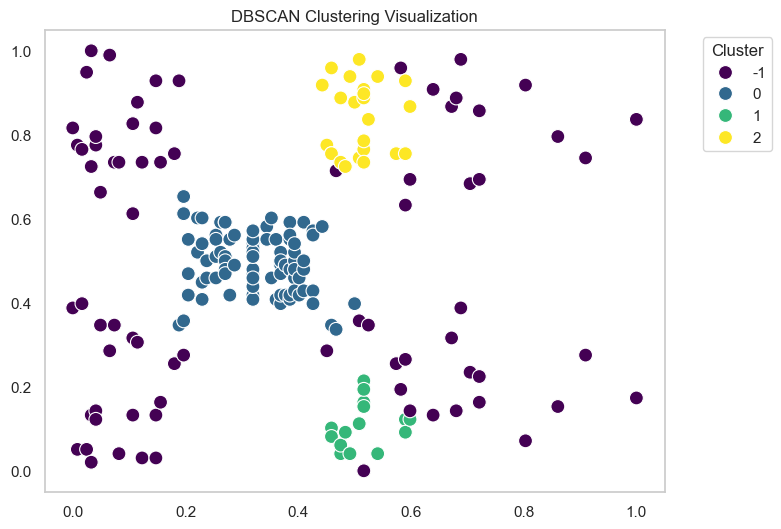

In [1378]:
eps_values = np.arange(0.1, 0.5, 0.01)
min_samples_values = range(2, 15)
metrics = ['euclidean', 'manhattan', 'cosine']

best_score = -1
best_eps = 0
best_min_samples = 0
best_metric = ''

for eps in eps_values:
    for min_samples in min_samples_values:
        for metric in metrics:
            db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
            labels = db.fit_predict(data_selection_np)

            if len(set(labels)) > 1: 
                valid_points = labels != -1
                if len(set(labels[valid_points])) > 1: 
                    score = silhouette_score(data_selection_np[valid_points], labels[valid_points])
                    if score > best_score:
                        best_score = score
                        best_eps = eps
                        best_min_samples = min_samples
                        best_metric = metric

print(f"Best Silhouette Score: {best_score}")
print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best metric: {best_metric}")

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, metric=best_metric)
labels = dbscan.fit_predict(data_selection_np)

plt.figure(figsize=(8, 6))

sns.scatterplot(x=data_selection_np[:, 0], y=data_selection_np[:, 1], hue=labels, palette='viridis', marker='o', s=100)

plt.title('DBSCAN Clustering Visualization')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

<h3>1.3. Optics models

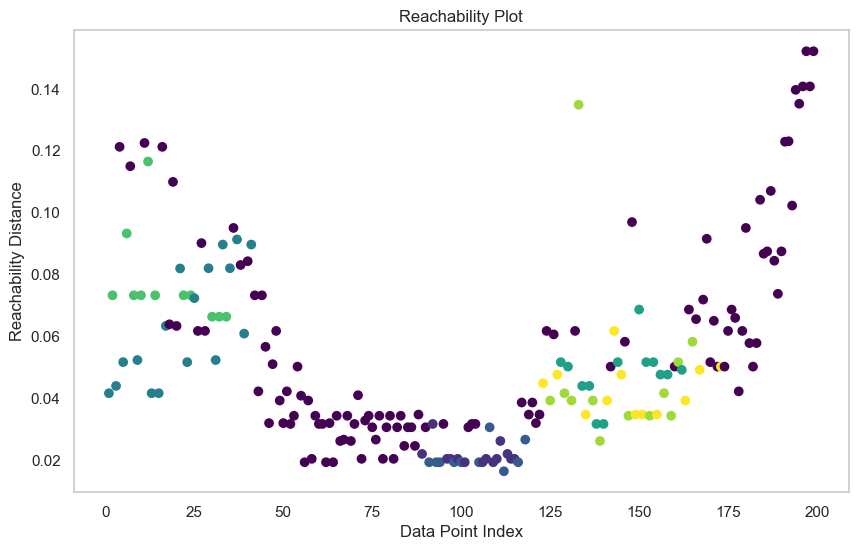

Silhouette Score: 0.6457645474750694


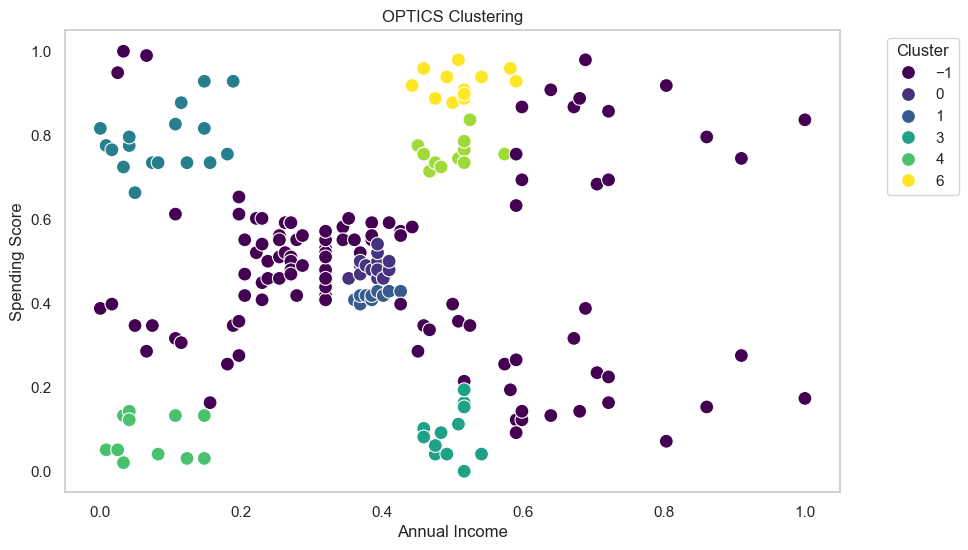

In [1379]:
optics_model = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05)
optics_model.fit(data_income_spending_score)

labels = optics_model.labels_
data_with_labels = pd.DataFrame(data_income_spending_score, columns=['Annual Income', 'Spending Score'])
data_with_labels['Cluster'] = labels

plt.figure(figsize=(10, 6))
plt.title('Reachability Plot')
plt.scatter(range(len(data_income_spending_score)), optics_model.reachability_, c=labels, cmap='viridis')
plt.xlabel('Data Point Index')
plt.ylabel('Reachability Distance')
plt.grid(False)
plt.show()

valid_points = data_with_labels['Cluster'] != -1
sil_score = silhouette_score(data_income_spending_score[valid_points], labels[valid_points])
print(f'Silhouette Score: {sil_score}')

plt.figure(figsize=(10, 6))
plt.title('OPTICS Clustering')
sns.scatterplot(x=data_selection_np[:, 0], y=data_selection_np[:, 1], hue=labels, palette='viridis', marker='o', s=100)
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(False)
plt.show()

The Silhouette score for the base OPTICS model is already quite good compared to the two previous counterparts. However, further tuning can be done to find the optimal result.

Best Parameters: {'min_samples': 5, 'xi': 0.2, 'min_cluster_size': 0.05}
Best Silhouette Score: 0.7941959081323198


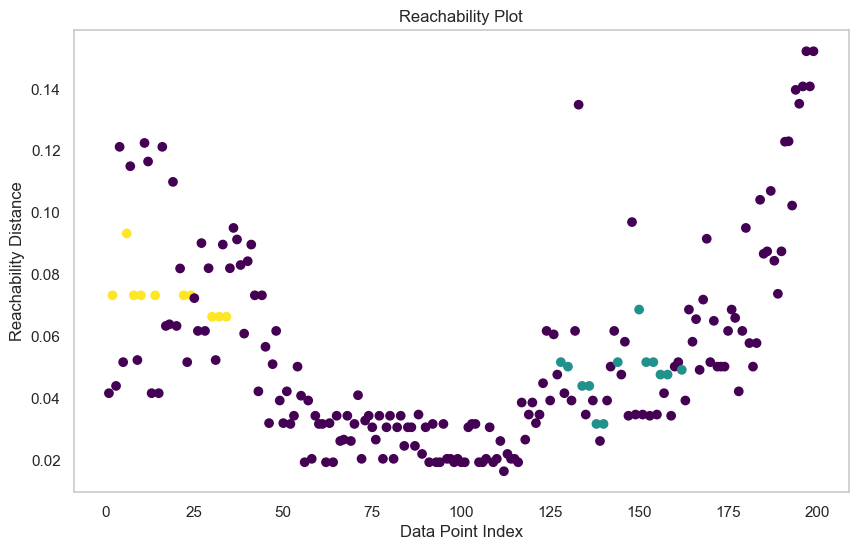

Silhouette Score: 0.7941959081323198


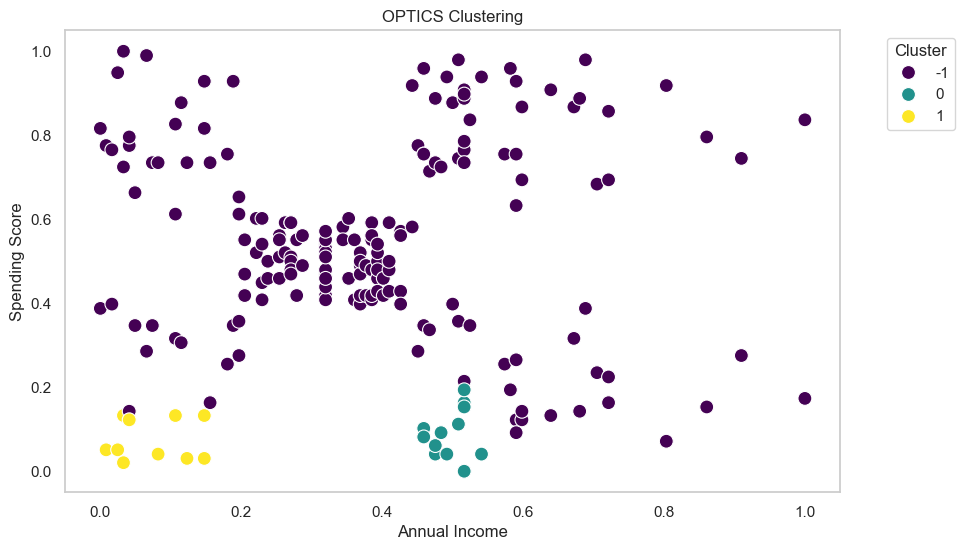

In [1380]:
sns.set(style="whitegrid", rc={'axes.grid': False})
plt.rcParams.update({'font.size': 12})

def tune_optics(data, min_samples_values, xi_values, min_cluster_size_values):
    best_score = -1
    best_params = {}

    for min_samples in min_samples_values:
        for xi in xi_values:
            for min_cluster_size in min_cluster_size_values:
                optics_model = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size)
                labels = optics_model.fit_predict(data)
                
                # Exclude noise points
                valid_points = labels != -1
                if len(set(labels[valid_points])) > 1:
                    score = silhouette_score(data[valid_points], labels[valid_points])
                    if score > best_score:
                        best_score = score
                        best_params = {
                            'min_samples': min_samples,
                            'xi': xi,
                            'min_cluster_size': min_cluster_size
                        }

    return best_params, best_score

min_samples_values = [3, 5, 10, 20]
xi_values = [0.01, 0.05, 0.1, 0.2]
min_cluster_size_values = [0.05, 0.1, 0.2]

best_params, best_score = tune_optics(data_income_spending_score, min_samples_values, xi_values, min_cluster_size_values)
print(f"Best Parameters: {best_params}")
print(f"Best Silhouette Score: {best_score}")

optics_model = OPTICS(min_samples=best_params['min_samples'], xi=best_params['xi'], min_cluster_size=best_params['min_cluster_size'])
optics_model.fit(data_income_spending_score)

labels = optics_model.labels_
data_with_labels = pd.DataFrame(data_income_spending_score, columns=['Annual Income', 'Spending Score'])
data_with_labels['Cluster'] = labels

plt.figure(figsize=(10, 6))
plt.title('Reachability Plot')
plt.scatter(range(len(data_income_spending_score)), optics_model.reachability_, c=labels, cmap='viridis')
plt.xlabel('Data Point Index')
plt.ylabel('Reachability Distance')
plt.grid(False)
plt.show()

valid_points = data_with_labels['Cluster'] != -1
sil_score = silhouette_score(data_income_spending_score[valid_points], labels[valid_points])
print(f'Silhouette Score: {sil_score}')

plt.figure(figsize=(10, 6))
plt.title('OPTICS Clustering')
sns.scatterplot(x=data_selection_np[:, 0], y=data_selection_np[:, 1], hue=labels, palette='viridis', marker='o', s=100)
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(False)
plt.show()

<h1>IV. Evaluation 

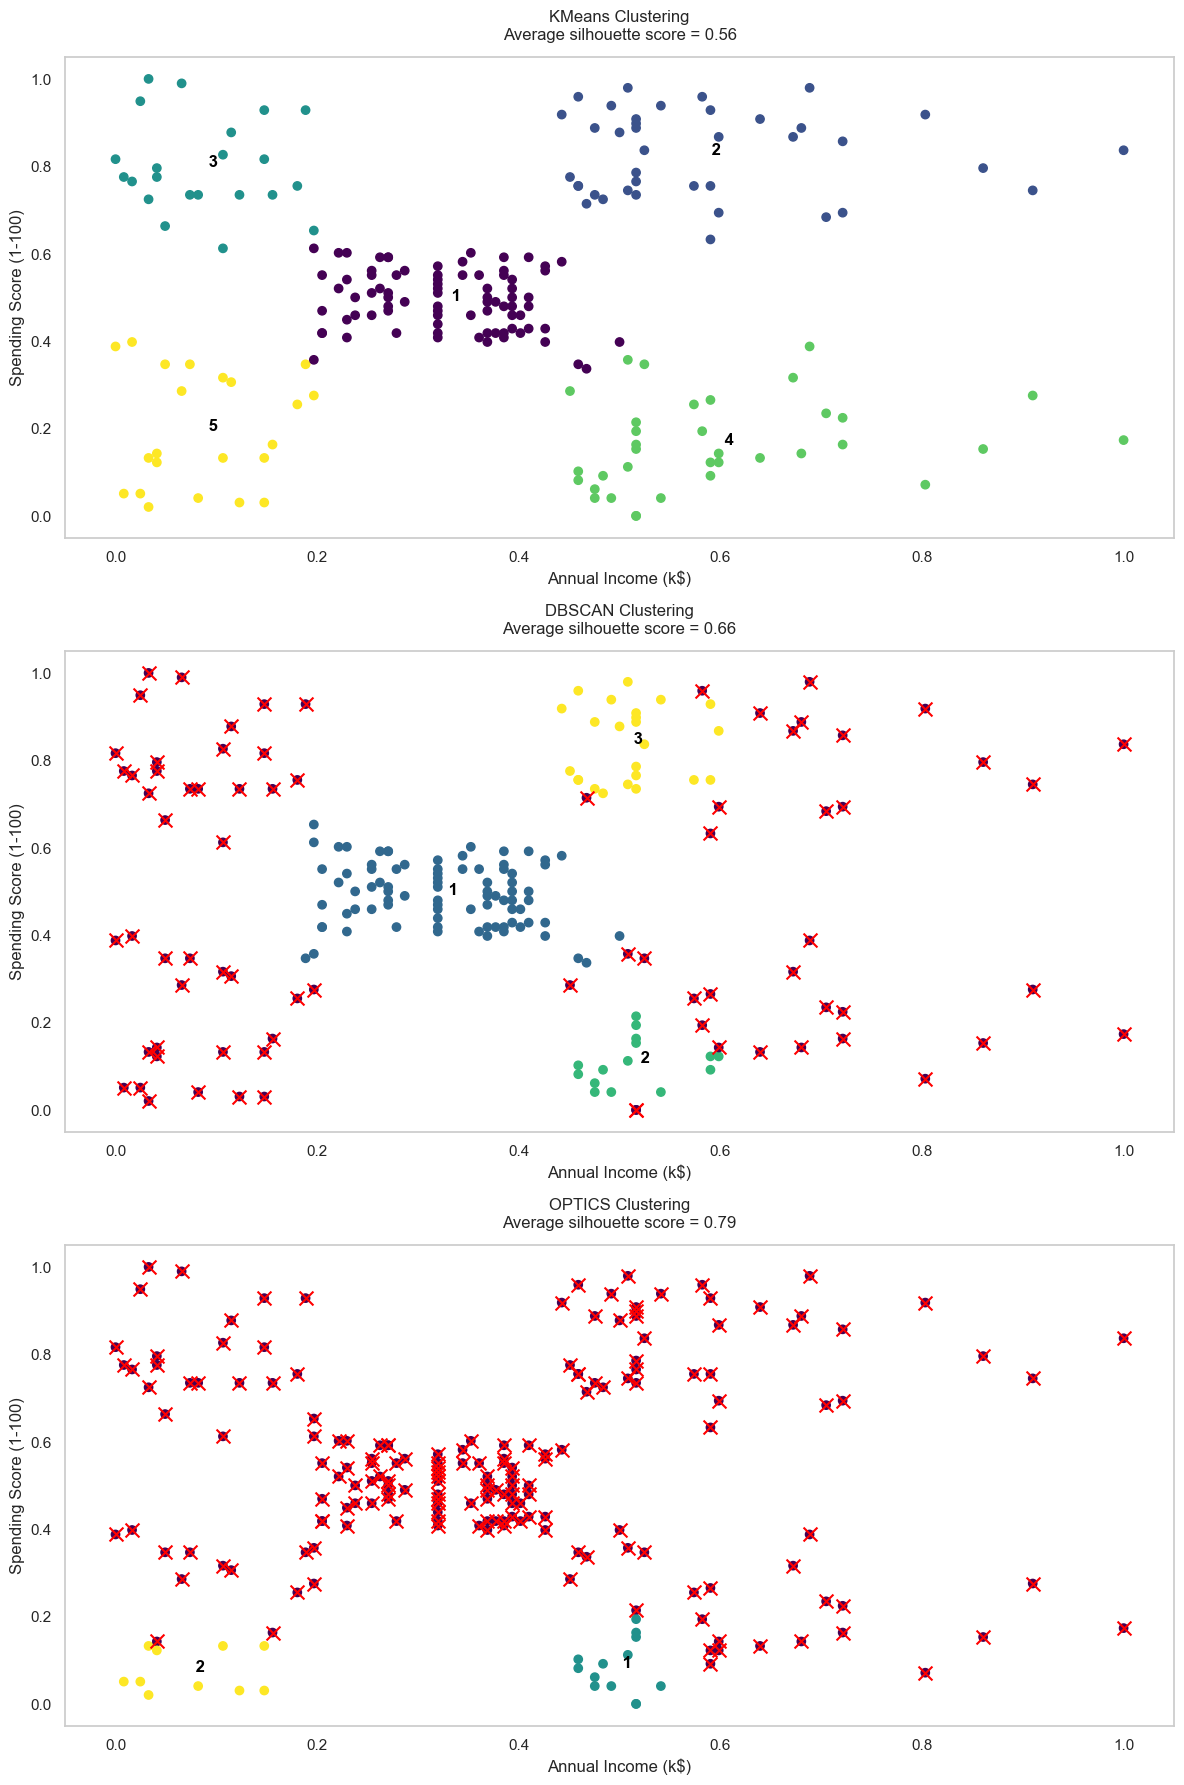

In [1381]:
kmeans = KMeans(n_clusters=5)
kmeans_labels = kmeans.fit_predict(data_selection_np)
kmeans_silhouette = silhouette_score(data_selection_np, kmeans_labels)

dbscan = DBSCAN(eps=0.12, min_samples=14, metric='manhattan')
dbscan_labels = dbscan.fit_predict(data_selection_np)
valid_points_dbscan = dbscan_labels != -1
dbscan_silhouette = silhouette_score(data_selection_np[valid_points_dbscan], dbscan_labels[valid_points_dbscan])

optics = OPTICS(min_samples=5, xi=0.2, min_cluster_size=0.05)
optics_labels = optics.fit_predict(data_selection_np)
valid_points_optics = optics_labels != -1
optics_silhouette = silhouette_score(data_selection_np[valid_points_optics], optics_labels[valid_points_optics])

fig, axs = plt.subplots(3, 1, figsize=(12, 18))

axs[0].scatter(data_selection_np[:, 0], data_selection_np[:, 1], c=kmeans_labels, cmap='viridis')
for label in np.unique(kmeans_labels):
    cluster_mask = kmeans_labels == label
    cluster_center = np.mean(data_selection_np[cluster_mask], axis=0)
    axs[0].text(cluster_center[0], cluster_center[1], f' {label+1}', fontsize=12, color='black', weight='bold')

axs[0].set_xlabel('Annual Income (k$)')
axs[0].set_ylabel('Spending Score (1-100)')
axs[0].set_title(f'KMeans Clustering\nAverage silhouette score = {kmeans_silhouette:.2f}', y=1.02)
axs[0].grid(False)

axs[1].scatter(data_selection_np[:, 0], data_selection_np[:, 1], c=dbscan_labels, cmap='viridis')
for label in np.unique(dbscan_labels):
    if label != -1:
        cluster_mask = dbscan_labels == label
        cluster_center = np.mean(data_selection_np[cluster_mask], axis=0)
        axs[1].text(cluster_center[0], cluster_center[1], f' {label+1}', fontsize=12, color='black', weight='bold')
    else:
        outlier_mask = dbscan_labels == -1
        axs[1].scatter(data_selection_np[outlier_mask, 0], data_selection_np[outlier_mask, 1], marker='x', c='red', s=100)

axs[1].set_xlabel('Annual Income (k$)')
axs[1].set_ylabel('Spending Score (1-100)')
axs[1].set_title(f'DBSCAN Clustering\nAverage silhouette score = {dbscan_silhouette:.2f}', y=1.02)
axs[1].grid(False)

axs[2].scatter(data_selection_np[:, 0], data_selection_np[:, 1], c=optics_labels, cmap='viridis')
for label in np.unique(optics_labels):
    if label != -1:
        cluster_mask = optics_labels == label
        cluster_center = np.mean(data_selection_np[cluster_mask], axis=0)
        axs[2].text(cluster_center[0], cluster_center[1], f' {label+1}', fontsize=12, color='black', weight='bold')
    else:
        outlier_mask = optics_labels == -1
        axs[2].scatter(data_selection_np[outlier_mask, 0], data_selection_np[outlier_mask, 1], marker='x', c='red', s=100)

axs[2].set_xlabel('Annual Income (k$)')
axs[2].set_ylabel('Spending Score (1-100)')
axs[2].set_title(f'OPTICS Clustering\nAverage silhouette score = {optics_silhouette:.2f}', y=1.02)
axs[2].grid(False)

plt.tight_layout()
plt.show()

- KMeans: Provides reasonably well-defined clusters but does not identify outliers.
- DBSCAN: Performs better than KMeans with well-defined clusters and effective noise detection.
- OPTICS: Offers the best clustering performance with the highest silhouette score and effective noise detection.

Given the context of customer segmentation, OPTICS appears to be the most suitable model for this dataset due to its highest silhouette score and ability to handle varying cluster densities and shapes, along with outlier identification. If your primary goal is to identify well-defined clusters while also recognizing noise in the data, OPTICS would be the recommended choice.

The parameters for models were tuned to achieve these result.